# File Description

This notebook is for determining the best way to discretise the MSL data from Antonio

# File Setup

##
How does the order of magnitude vary betwene the lagoon and the ocean?
which is most sensitive to waves? How would that interact with topography?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import sys
import json
sys.path.append('C:\\Users\\shannonb\\Documents\\Model_and_data\\python_classes')
import rpy2
import copy
os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
%load_ext rpy2.ipython

from BNModel import BNModel

from BN_Antonio_preprocessing import *


C:\ProgramData\Anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [3]:
### set location of file storage
folder = 'BN_antonio_data'
try:
    os.makedirs(folder)
except FileExistsError:
    pass

# Data Prep

In [4]:
# Import and preprocess data
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon()
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean()

In [5]:
### HOW TO INCLUDE TEMPORAL ASPECT ??

## Create Variable Dictionary

In [6]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
lagoon_model_dict = {
    'variables':{
        'Wind':{
            'label':'Wind Speed (m/s)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['MSL']
        },
        'WindDir':{
            'label':r'Wind Direction (degrees)',
            'discretisation':{
                'n_bins':8,
                'strategy':'uniform',
                'bin_names':['WNW','NNW','NNE','ENE','ESE','SSE','SSW','WSW']
            },
            'child_nodes':['MSL']
        },
        'Hs_offshore':{
            'label':'Offshore wave height (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['MSL']
        },
        'Tm_offshore':{
            'label':'Offshore wave period (s)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['MSL']
        },
        'Dir_offshore':{
            'label':r'Offshore wave direction (degrees)',
            'discretisation':{
                'n_bins':8,
                'strategy':'kmeans',
                'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
            },
            'child_nodes':['MSL']
        },
        'TWL_point_110':{
            'label':'Total water level at point 110 (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':[]
        },
        'TWL_point_110_less_Tide':{
            'label':'Total water level at point 110 less tide (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_110']
        },
        'Hs_point_110':{
            'label':'Wave height at point 110 (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_110_less_Tide']
        },
        'MSL':{
            'label':'Mean sea level (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_110_less_Tide']
        },
        'MEI':{
            'label':'Multivariate ENSO index',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['LaNiña','none','ElNiño'],
                'bin_edges':[-3.0,-0.5,0.5,3.0]
            },
            'child_nodes':['MSL']
        },
        'Tide':{
            'label':'Tide (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_110']
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':3
}

In [7]:
ocean_model_dict = {
   'variables':{
       'Tm_point_218':{
            'label':'Wave period at point 218 (s)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_218_less_Tide']
        },
        'Hs_point_218':{
            'label':'Wave height at point 218 (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_218_less_Tide']
        },
        'MSL':{
            'label':'Mean sea level (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_218_less_Tide']
        },
        'MEI':{
            'label':'Multivariate ENSO index',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['LaNiña','none','ElNiño'],
                'bin_edges':[-3.0,-0.5,0.5,3.0]
            },
            'child_nodes':['MSL']
        },
        'Tide':{
            'label':'Tide (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_218']
        },
        'TWL_point_218':{
            'label':'Total water level at point 218 (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':[]
        },
        'TWL_point_218_less_Tide':{
            'label':'Total water level at point 218 less tide (m)',
            'discretisation':{
                'n_bins':7,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']
            },
            'child_nodes':['TWL_point_218']
        }
   },
    'training_frac':0.8,
    'bootstrap_reps':3
}

# Get Binning for MSL

In [8]:
# Load SLR Projections
data_location = "C:\\Users\\shannonb\\Documents\\Model_and_data\\Dataset\\D7_MSL_projections\\"
file_name = "distributions_dict"
with open("{}{}.json".format(data_location,file_name), 'r') as fp:
    SL_proj_dict = json.load(fp)
    
def SLR_proj_extractor(SL_proj_dict,AIS_config,rcp,year):
    '''
    Function for getting SLR projections for a given Antarctic icesheet, rcp and year
    Years start as 2020 and go up in lots of 10 until 2150 (2100 for dp16)
    '''
    SLR_prob_dict = SL_proj_dict["('{}', '{}', {})".format(AIS_config,rcp,year)]
    SLR_median_prob = np.max([float(x) for x in list(SLR_prob_dict.keys())])
    SLR_median_MSL = float(SLR_prob_dict[str(SLR_median_prob)])/1000 #units is m

    return(SLR_median_MSL)

# Get sea-level projections
k14_26_2050 = SLR_proj_extractor(SL_proj_dict,'k14','26','2050')
k14_85_2050 = SLR_proj_extractor(SL_proj_dict,'k14','85','2050')
k14_26_2100 = SLR_proj_extractor(SL_proj_dict,'k14','26','2100')
k14_85_2100 = SLR_proj_extractor(SL_proj_dict,'k14','85','2100')

dp21_26_2050 = SLR_proj_extractor(SL_proj_dict,'dp21','26','2050')
dp21_85_2050 = SLR_proj_extractor(SL_proj_dict,'dp21','85','2050')
dp21_26_2100 = SLR_proj_extractor(SL_proj_dict,'dp21','26','2100')
dp21_85_2100 = SLR_proj_extractor(SL_proj_dict,'dp21','85','2100')

# Add worse case scenario 
MSL_adjusted_dict = copy.deepcopy(lagoon_data_dict)
MSL_adjusted_dict['MSL'] = MSL_adjusted_dict['MSL']+dp21_85_2100

df_MSL_adjusted = copy.deepcopy(df_lagoon)
df_MSL_adjusted['MSL'] = df_MSL_adjusted['MSL']+dp21_85_2100

# Create a copy of the model dict to edit
MSL_model_dict = copy.deepcopy(lagoon_model_dict)

# Bootstrap and discretise data, and add it to the model_dict
MSL_adjusted_model_dict = BNModel().bootstrap_data(MSL_model_dict,MSL_adjusted_dict,df_MSL_adjusted)
MSL_adjusted_model_dict = BNModel().discretiser(MSL_adjusted_model_dict)

# Adjust lagoon model dict to have MSL bin edges in it to use for discretisation of actual dict
lagoon_model_dict['variables']['MSL']['discretisation'].update(
    {'bin_edges':MSL_adjusted_model_dict['variables']['MSL']['bin_edges'][0]
    })

## Bootstrapping the data

In [9]:
# Bootstrap the data, and add it to the model_dict
lagoon_model_dict = BNModel().bootstrap_data(lagoon_model_dict,lagoon_data_dict,df_lagoon)

ocean_model_dict = BNModel().bootstrap_data(ocean_model_dict,ocean_data_dict,df_ocean)

## Discretise the data

In [10]:
# Discretise the data
lagoon_file_label = "lagoon"
ocean_file_label = "ocean"

lagoon_model_dict = BNModel().discretiser(lagoon_model_dict)
ocean_model_dict = BNModel().discretiser(ocean_model_dict)

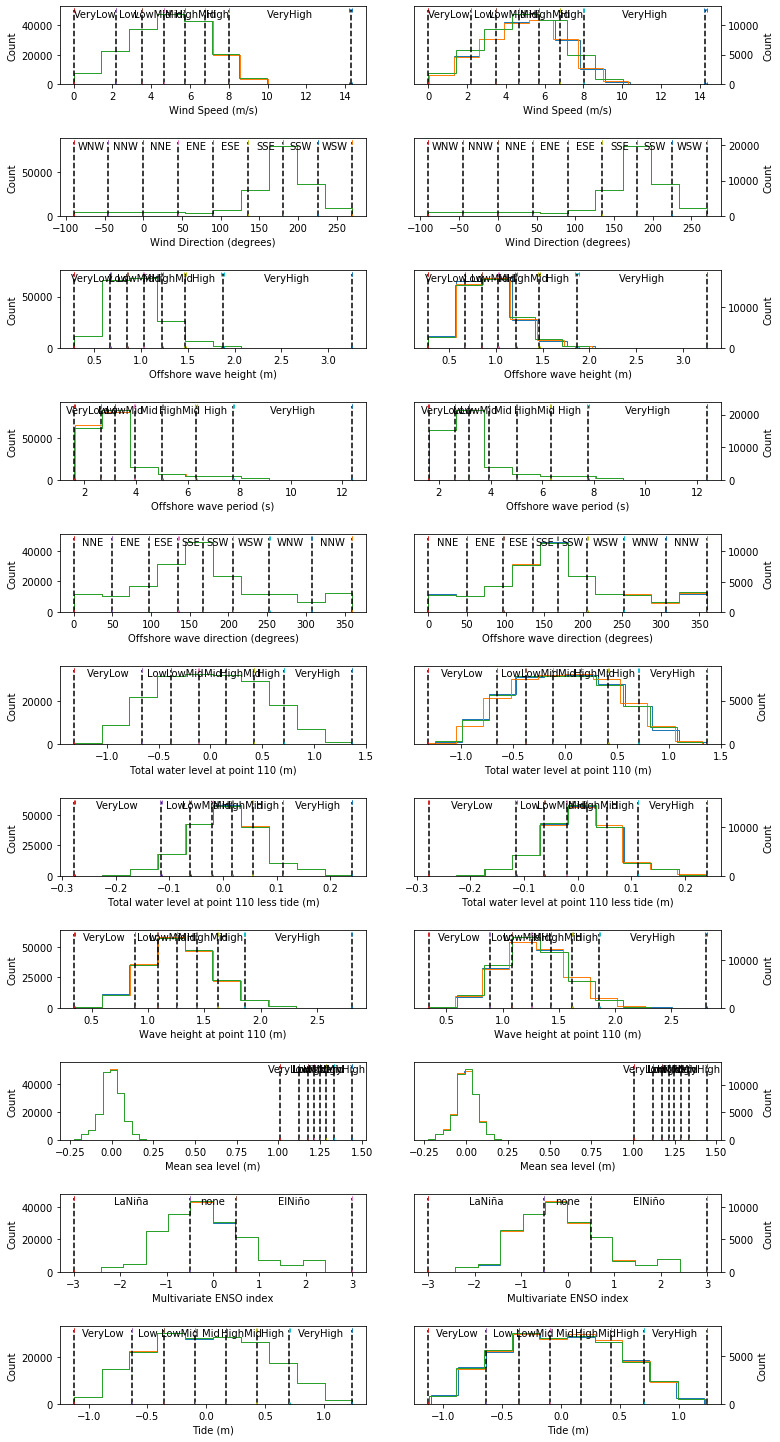

In [11]:
lagoon_disc_fig = BNModel().plot_discretiser(lagoon_model_dict)

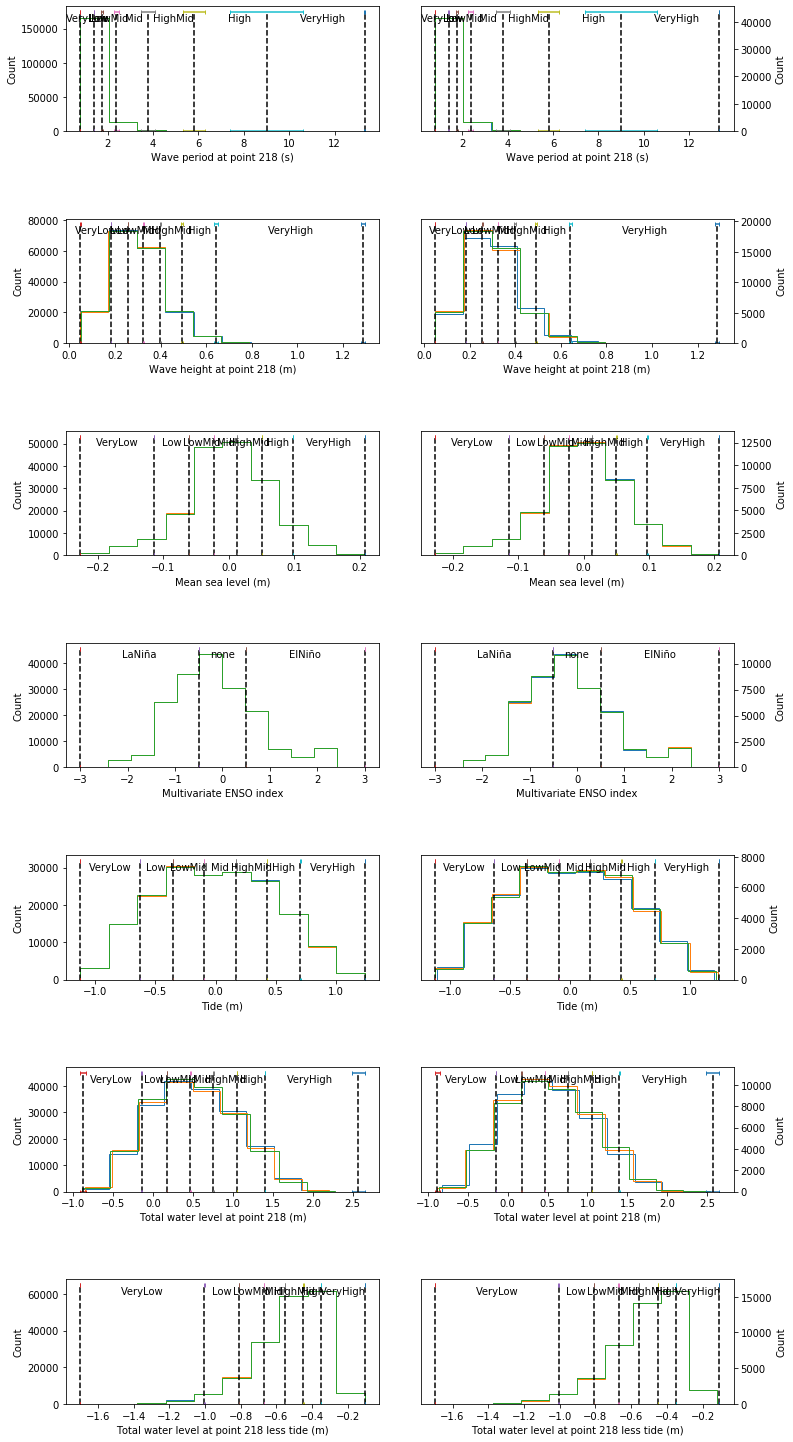

In [12]:
ocean_disc_fig = BNModel().plot_discretiser(ocean_model_dict)

## Save the data

In [13]:
BNModel().save_dataset(lagoon_model_dict,lagoon_file_label)
BNModel().save_dataset(ocean_model_dict,ocean_file_label)

# Create BN Model

In [14]:
# Create the BN
lagoon_model_dict = BNModel().create_SM(lagoon_model_dict,lagoon_file_label)
ocean_model_dict = BNModel().create_SM(ocean_model_dict,ocean_file_label)

## View Conditional Probability tables

In [15]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(lagoon_model_dict,'TWL_point_110')

TWL_point_110_less_Tide   VeryLow                                        \
Tide                      VeryLow       Low   LowMid      Mid   HighMid   
TWL_point_110                                                             
High                     0.000000  0.000000  0.00000  0.00000  0.581033   
HighMid                  0.000000  0.000000  0.00000  0.61797  0.418967   
Low                      0.628945  0.334932  0.00000  0.00000  0.000000   
LowMid                   0.000000  0.663469  0.38497  0.00000  0.000000   
Mid                      0.000000  0.001599  0.61503  0.38203  0.000000   
VeryHigh                 0.000000  0.000000  0.00000  0.00000  0.000000   
VeryLow                  0.371055  0.000000  0.00000  0.00000  0.000000   

TWL_point_110_less_Tide                         Low                      ...  \
Tide                         High VeryHigh  VeryLow       Low    LowMid  ...   
TWL_point_110                                                            ...   
High                     0.545296      0.0  0.00000  0.000000  0.000000  ...   
HighMid                  0.000000      0.0  0.00000  0.000000  0.000000  ...   
Low                      0.000000      0.0  0.41215  0.554066  0.000000  ...   
LowMid                   0.000000      0.0  0.00000  0.445934  0.618753  ...   
Mid                      0.000000      0.0  0.00000  0.000000  0.381247  ...   
VeryHigh                 0.454704      1.0  0.00000  0.000000  0.000000  ...   
VeryLow                  0.000000      0.0  0.58785  0.000000  0.000000  ...   

TWL_point_110_less_Tide      High                     VeryHigh            \
Tide                      HighMid      High  VeryHigh  VeryLow       Low   
TWL_point_110                                                              
High                     0.000000  0.713713  0.322111      0.0  0.000000   
HighMid                  0.770931  0.286287  0.000000      0.0  0.000000   
Low                      0.000000  0.000000  0.000000      0.0  0.608669   
LowMid                   0.000000  0.000000  0.000000      0.0  0.000000   
Mid                      0.229069  0.000000  0.000000      0.0  0.000000   
VeryHigh                 0.000000  0.000000  0.677889      0.0  0.000000   
VeryLow                  0.000000  0.000000  0.000000      1.0  0.391331   

TWL_point_110_less_Tide                                                    
Tide                       LowMid       Mid   HighMid      High  VeryHigh  
TWL_point_110                                                              
High                     0.000000  0.000000  0.000000  0.440989  0.582353  
HighMid                  0.000000  0.000000  0.490811  0.559011  0.000000  
Low                      0.505426  0.000000  0.000000  0.000000  0.000000  
LowMid                   0.494574  0.471633  0.000000  0.000000  0.000000  
Mid                      0.000000  0.528367  0.509189  0.000000  0.000000  
VeryHigh                 0.000000  0.000000  0.000000  0.000000  0.417647  
VeryLow                  0.000000  0.000000  0.000000  0.000000  0.000000  

[7 rows x 49 columns]

In [16]:
# Get conditional probs tables
df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'MSL')

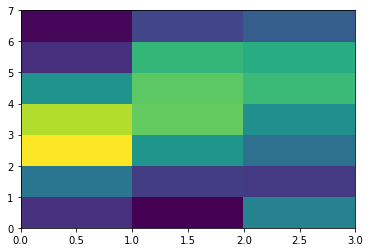

In [17]:
df_CPT_MSL = df_CPT_MSL[['LaNiña','none','ElNiño']]
df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','LowMid','Mid','HighMid','High','VeryHigh']]

plt.pcolor(df_CPT_MSL)

In [18]:
df_CPT_MSL.T

MSL,VeryLow,Low,LowMid,Mid,HighMid,High,VeryHigh
MEI,,,,,,,
LaNiña,0.048922,0.127330,0.318491,0.282166,0.165664,0.046838,0.010588
none,0.004781,0.060007,0.169815,0.243283,0.239542,0.212476,0.070096
ElNiño,0.144479,0.058356,0.121041,0.160289,0.217210,0.200796,0.097830


            LaNiña      none    ElNiño
MSL                                   
VeryLow   0.246855  0.024125  0.729020
Low       0.518249  0.244237  0.237514
LowMid    0.522676  0.278683  0.198641
Mid       0.411478  0.354775  0.233747
HighMid   0.266163  0.384859  0.348978
High      0.101797  0.461794  0.436409
VeryHigh  0.059314  0.392665  0.548022


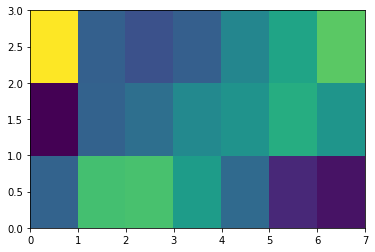

In [19]:

atest_dict = {}

for index,row in df_CPT_MSL.T.iterrows():
    atest_dict.update({index:(row/np.sum(df_CPT_MSL.T))})
    
#     print(row)
print(pd.DataFrame(atest_dict))

plt.pcolor(pd.DataFrame(atest_dict).T)

# Set Evidence

In [20]:
lagoon_evidence_dict = {
    'Wind':[0.05,0.8,0.05,0.1,0.01,0.01,0.01],
    'WindDir':[0.05,0.8,0.05,0.1,0.01,0.01,0.01,0.01]
}

ocean_evidence_dict = {
    'Tide':[0.05,0.8,0.05,0.1,0.01,0.01,0.01],
    'MSL':[0.05,0.8,0.05,0.1,0.01,0.01,0.01]
}

In [21]:
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,lagoon_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,ocean_evidence_dict)

# Update beliefs based on evidence

In [22]:
# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)
ocean_model_dict = BNModel().update_evidence(ocean_model_dict)

# BN Visualisation

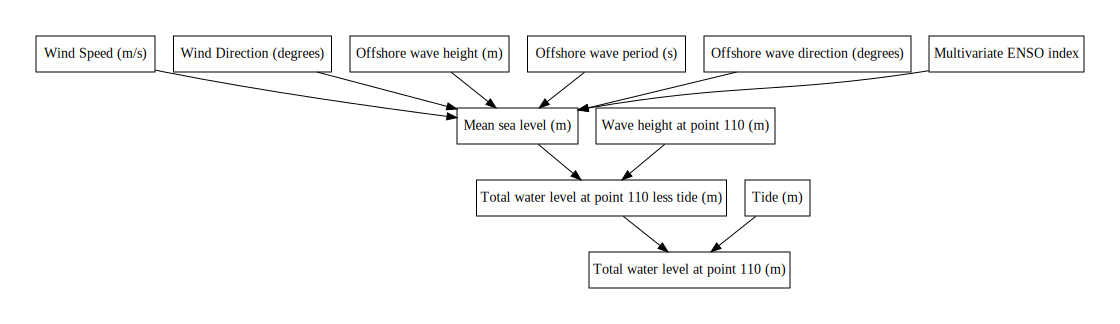

In [23]:

# Set up graph
graph_lagoon = BNModel().create_BN_graph()

# Create nodes of the graph
graph_lagoon,lagoon_model_dict = BNModel().create_nodes(graph_lagoon,lagoon_model_dict,1)

# Create arcs between nodesb
graph_lagoon = BNModel().create_arcs(graph_lagoon,lagoon_model_dict)

# Save as dot file
graph_lagoon.render(filename='graph_lagoon',format='png')

# Plot the graph
graph_lagoon


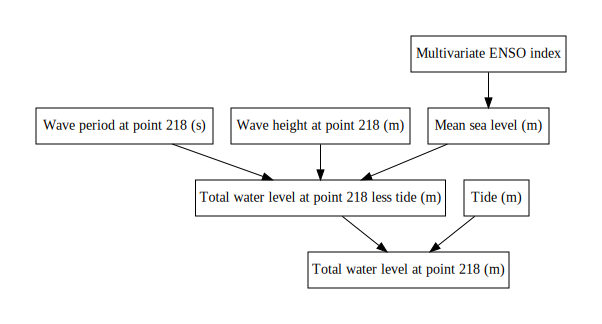

In [24]:

# Set up graph
graph_ocean = BNModel().create_BN_graph()

# Create nodes of the graph
graph_ocean,ocean_model_dict = BNModel().create_nodes(graph_ocean,ocean_model_dict,1)

# Create arcs between nodesb
graph_ocean = BNModel().create_arcs(graph_ocean,ocean_model_dict)

# Save as dot file
graph_ocean.render(filename='graph_ocean',format='png')

# Plot the graph
graph_ocean

# Model Validation

{(0, 'VeryLow'): 0.9021210782147592, (0, 'Low'): 0.8012688108586604, (0, 'LowMid'): 0.8153827430935865, (0, 'Mid'): 0.8236327145007526, (0, 'HighMid'): 0.8049912214697768, (0, 'High'): 0.8233106013639182, (0, 'VeryHigh'): 0.8517203713817586, (1, 'VeryLow'): 0.9021210782147592, (1, 'Low'): 0.8012688108586604, (1, 'LowMid'): 0.8153827430935865, (1, 'Mid'): 0.8236327145007526, (1, 'HighMid'): 0.8049912214697768, (1, 'High'): 0.8233106013639182, (1, 'VeryHigh'): 0.8517203713817586, (2, 'VeryLow'): 0.9021210782147592, (2, 'Low'): 0.8012688108586604, (2, 'LowMid'): 0.8153827430935865, (2, 'Mid'): 0.8236327145007526, (2, 'HighMid'): 0.8049912214697768, (2, 'High'): 0.819590824550527, (2, 'VeryHigh'): 0.855816493719279}


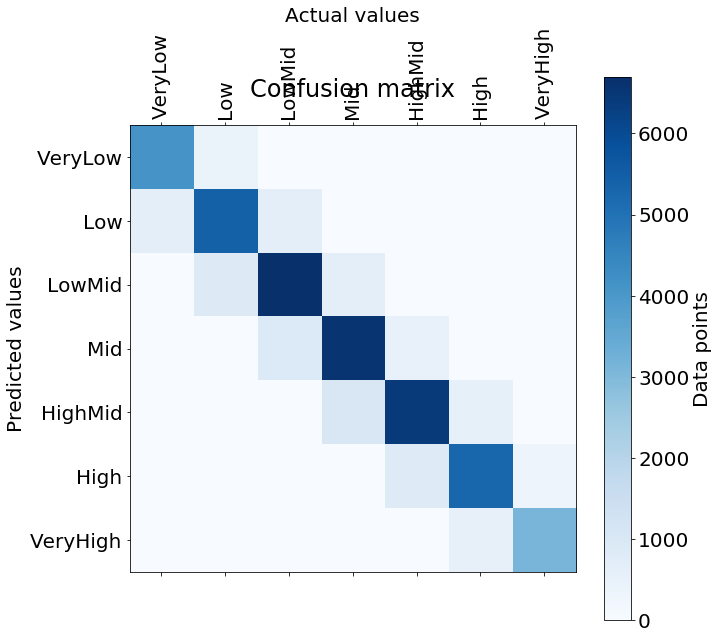

In [25]:
### Research picking number of kfolds 

lagoon_acc_dict = BNModel().get_accuracies(lagoon_model_dict,"TWL_point_110")

print(lagoon_acc_dict)

fig, ax = BNModel().confusion_matrix(lagoon_model_dict,"TWL_point_110",1)

{(0, 'VeryLow'): 0.8677752991279659, (0, 'Low'): 0.8328643093111464, (0, 'LowMid'): 0.706571976101905, (0, 'Mid'): 0.7239470517448857, (0, 'HighMid'): 0.8512763596004439, (0, 'High'): 0.7096301720981325, (0, 'VeryHigh'): 0.8329947175944737, (1, 'VeryLow'): 0.8678977272727273, (1, 'Low'): 0.8015173764072443, (1, 'LowMid'): 0.7305308238476277, (1, 'Mid'): 0.7237063778580024, (1, 'HighMid'): 0.8487161693268563, (1, 'High'): 0.7355417276720352, (1, 'VeryHigh'): 0.8329955411430888, (2, 'VeryLow'): 0.8677484787018256, (2, 'Low'): 0.8327419552184021, (2, 'LowMid'): 0.7066711742168131, (2, 'Mid'): 0.7236525505293552, (2, 'HighMid'): 0.828012215435869, (2, 'High'): 0.6833150384193194, (2, 'VeryHigh'): 0.8329947175944737}


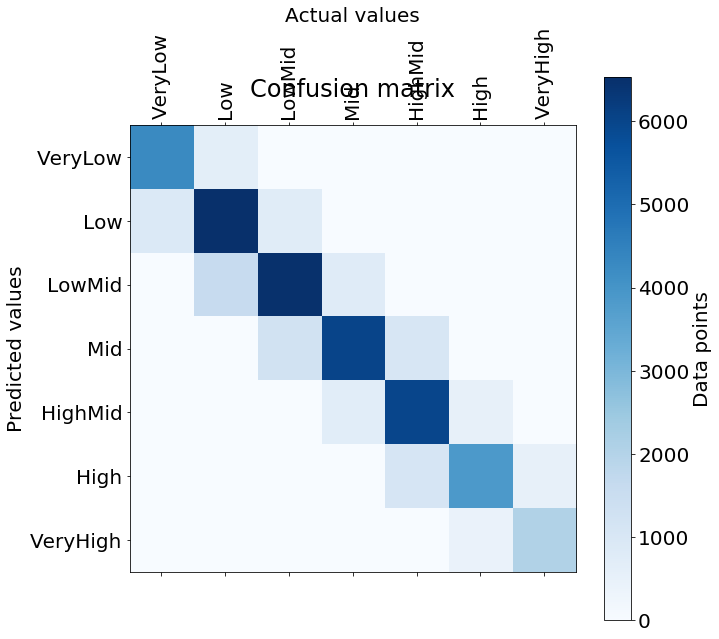

In [26]:

ocean_acc_dict = BNModel().get_accuracies(ocean_model_dict,"TWL_point_218")

print(ocean_acc_dict)

fig, ax = BNModel().confusion_matrix(ocean_model_dict,"TWL_point_218",1)

# Sensitivity Analysis

## Lagoon

### Tide on TWL

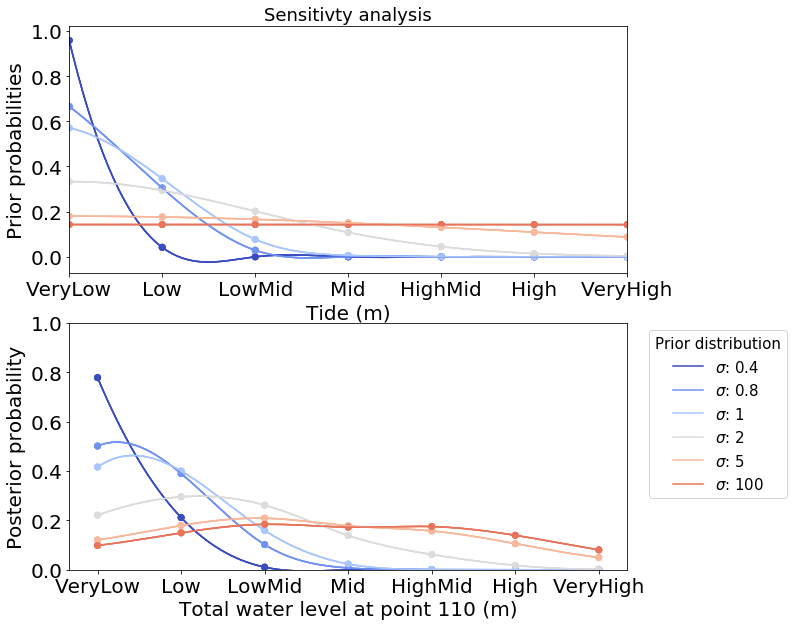

({0:           0.4           0.8           1.0       2.0       5.0       100.0
  0  7.777458e-01  5.007495e-01  4.159038e-01  0.221167  0.120652  0.098511
  1  2.115540e-01  3.895843e-01  3.999068e-01  0.295363  0.179346  0.149602
  2  1.069076e-02  1.020764e-01  1.592188e-01  0.261712  0.208824  0.183958
  3  9.407372e-06  7.461365e-03  2.345084e-02  0.138959  0.178016  0.172659
  4  1.404298e-13  1.279195e-04  1.483917e-03  0.061941  0.157311  0.175010
  5  3.875177e-23  4.629414e-07  3.567356e-05  0.017916  0.105828  0.139639
  6  1.246042e-35  2.149616e-10  2.032773e-07  0.002943  0.050024  0.080621,
  1:           0.4           0.8           1.0       2.0       5.0       100.0
  0  7.777458e-01  5.007495e-01  4.159038e-01  0.221167  0.120652  0.098511
  1  2.115540e-01  3.895843e-01  3.999068e-01  0.295363  0.179346  0.149602
  2  1.069076e-02  1.020764e-01  1.592188e-01  0.261712  0.208824  0.183958
  3  9.407372e-06  7.461365e-03  2.345084e-02  0.138959  0.178016  0.172659
  4  

In [27]:
df_tide_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','VeryLow','TWL_point_110')
df_tide_VL_post



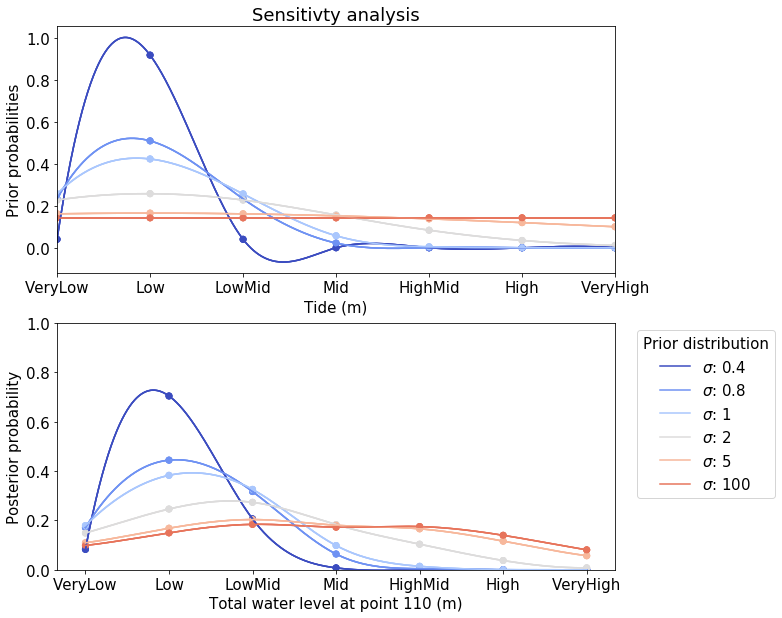

({0:           0.4           0.8       1.0       2.0       5.0       100.0
  0  8.280200e-02  1.710750e-01  0.178860  0.148862  0.109265  0.098483
  1  7.034912e-01  4.438631e-01  0.382332  0.245948  0.168180  0.149574
  2  2.059272e-01  3.167390e-01  0.325432  0.273177  0.203360  0.183941
  3  7.778998e-03  6.392122e-02  0.098335  0.182849  0.180337  0.172660
  4  5.936246e-07  4.331061e-03  0.014209  0.103649  0.165900  0.175029
  5  8.485635e-14  7.038364e-05  0.000819  0.037645  0.116003  0.139668
  6  1.413402e-23  1.541801e-07  0.000012  0.007870  0.056956  0.080645,
  1:           0.4           0.8       1.0       2.0       5.0       100.0
  0  8.280200e-02  1.710750e-01  0.178860  0.148862  0.109265  0.098483
  1  7.034912e-01  4.438631e-01  0.382332  0.245948  0.168180  0.149574
  2  2.059272e-01  3.167390e-01  0.325432  0.273177  0.203360  0.183941
  3  7.778998e-03  6.392122e-02  0.098335  0.182849  0.180337  0.172660
  4  5.936246e-07  4.331061e-03  0.014209  0.103649  0.16

In [28]:
df_tide_L_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','Low','TWL_point_110')
df_tide_L_post

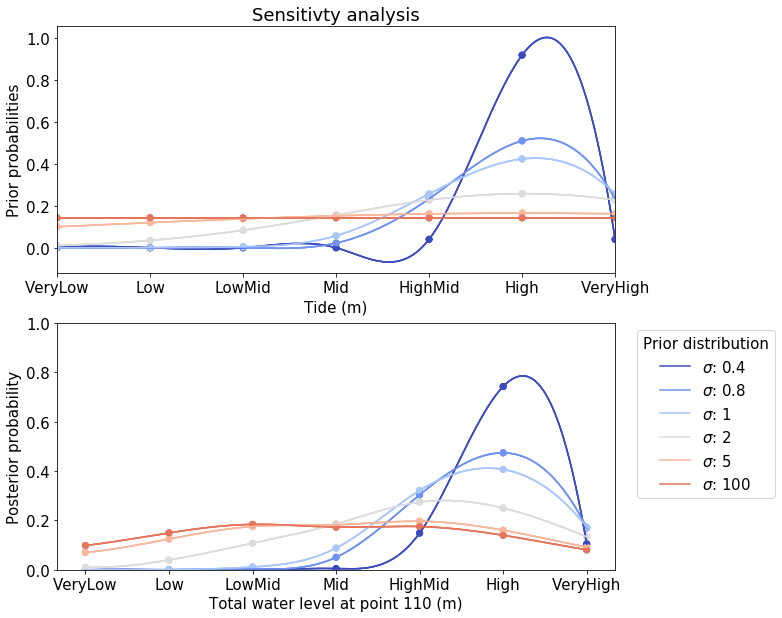

({0:           0.4           0.8       1.0       2.0       5.0       100.0
  0  1.308426e-23  1.437314e-07  0.000012  0.009607  0.070211  0.098375
  1  6.522947e-14  5.496088e-05  0.000676  0.039384  0.124499  0.149461
  2  3.732801e-07  2.970799e-03  0.011384  0.107634  0.175074  0.183872
  3  4.880136e-03  5.066771e-02  0.087904  0.185828  0.181896  0.172664
  4  1.486304e-01  3.032068e-01  0.321149  0.274185  0.196472  0.175104
  5  7.417613e-01  4.732700e-01  0.406170  0.249704  0.160345  0.139782
  6  1.047278e-01  1.698296e-01  0.172705  0.133658  0.091504  0.080741,
  1:           0.4           0.8       1.0       2.0       5.0       100.0
  0  1.308426e-23  1.437314e-07  0.000012  0.009607  0.070211  0.098375
  1  6.522947e-14  5.496088e-05  0.000676  0.039384  0.124499  0.149461
  2  3.732801e-07  2.970799e-03  0.011384  0.107634  0.175074  0.183872
  3  4.880136e-03  5.066771e-02  0.087904  0.185828  0.181896  0.172664
  4  1.486304e-01  3.032068e-01  0.321149  0.274185  0.19

In [29]:
df_tide_H_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','High','TWL_point_110')
df_tide_H_post

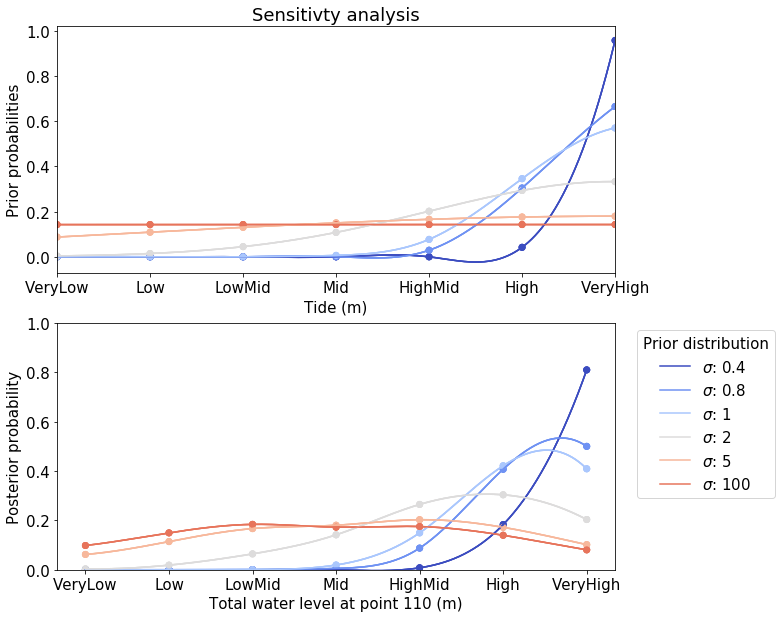

({0:           0.4           0.8           1.0       2.0       5.0       100.0
  0  1.350964e-35  2.180236e-10  2.039987e-07  0.003634  0.062142  0.098347
  1  3.488825e-23  3.906226e-07  3.021255e-05  0.018874  0.114218  0.149433
  2  1.034213e-13  8.979352e-05  1.122081e-03  0.064385  0.166791  0.183855
  3  6.999315e-07  5.512447e-03  1.938307e-02  0.141478  0.180311  0.172665
  4  8.049460e-03  8.780101e-02  1.495691e-01  0.264549  0.202720  0.175123
  5  1.829021e-01  4.070130e-01  4.210989e-01  0.303548  0.171964  0.139811
  6  8.090478e-01  4.995833e-01  4.087965e-01  0.203533  0.101854  0.080766,
  1:           0.4           0.8           1.0       2.0       5.0       100.0
  0  1.350964e-35  2.180236e-10  2.039987e-07  0.003634  0.062142  0.098347
  1  3.488825e-23  3.906226e-07  3.021255e-05  0.018874  0.114218  0.149433
  2  1.034213e-13  8.979352e-05  1.122081e-03  0.064385  0.166791  0.183855
  3  6.999315e-07  5.512447e-03  1.938307e-02  0.141478  0.180311  0.172665
  4  

In [30]:
df_tide_VH_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','VeryHigh','TWL_point_110')
df_tide_VH_post

### MSL on TWL less tide

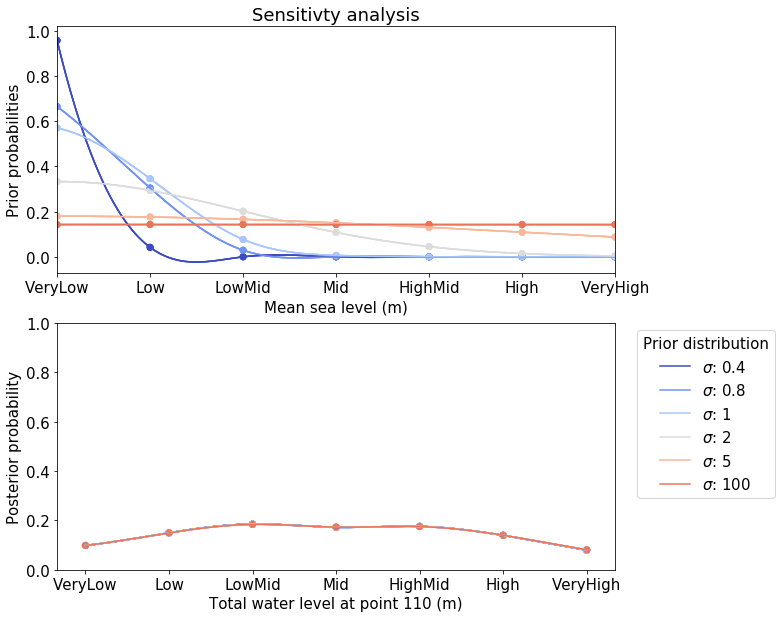

({0:       0.4       0.8       1.0       2.0       5.0       100.0
  0  0.098561  0.098547  0.098540  0.098511  0.098471  0.098455
  1  0.149674  0.149654  0.149645  0.149604  0.149548  0.149526
  2  0.185206  0.185031  0.184944  0.184582  0.184085  0.183891
  3  0.171984  0.172071  0.172114  0.172293  0.172540  0.172637
  4  0.175863  0.175755  0.175701  0.175477  0.175169  0.175049
  5  0.139322  0.139376  0.139403  0.139516  0.139670  0.139730
  6  0.079390  0.079566  0.079653  0.080017  0.080518  0.080713,
  1:       0.4       0.8       1.0       2.0       5.0       100.0
  0  0.098561  0.098547  0.098540  0.098511  0.098471  0.098455
  1  0.149674  0.149654  0.149645  0.149604  0.149548  0.149526
  2  0.185206  0.185031  0.184944  0.184582  0.184085  0.183891
  3  0.171984  0.172071  0.172114  0.172293  0.172540  0.172637
  4  0.175863  0.175755  0.175701  0.175477  0.175169  0.175049
  5  0.139322  0.139376  0.139403  0.139516  0.139670  0.139730
  6  0.079390  0.079566  0.079653

In [31]:
df_MSL_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,'MSL','VeryLow','TWL_point_110')
df_MSL_VL_post

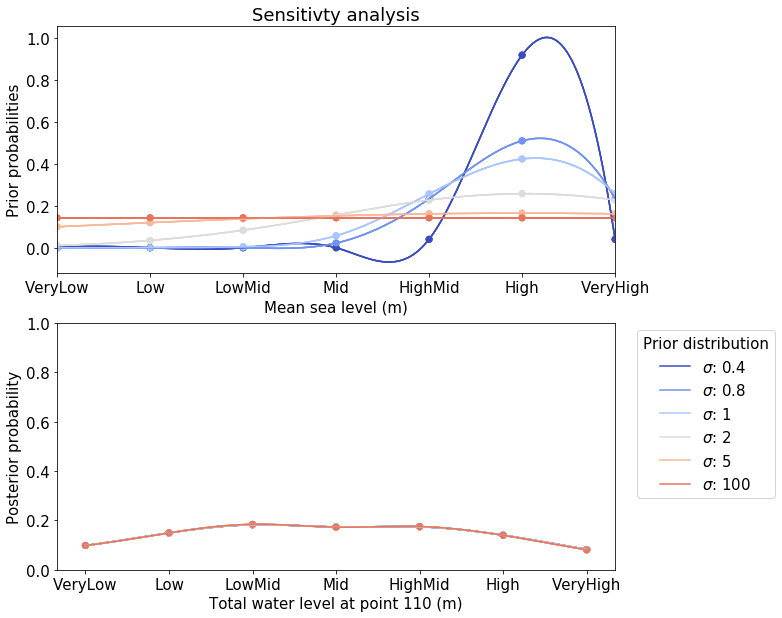

({0:       0.4       0.8       1.0       2.0       5.0       100.0
  0  0.098329  0.098329  0.098329  0.098346  0.098432  0.098455
  1  0.149349  0.149349  0.149349  0.149373  0.149493  0.149526
  2  0.182317  0.182317  0.182318  0.182536  0.183598  0.183889
  3  0.173417  0.173417  0.173417  0.173309  0.172782  0.172637
  4  0.174074  0.174074  0.174074  0.174209  0.174868  0.175048
  5  0.140218  0.140218  0.140218  0.140150  0.139820  0.139730
  6  0.082296  0.082296  0.082296  0.082077  0.081007  0.080714,
  1:       0.4       0.8       1.0       2.0       5.0       100.0
  0  0.098329  0.098329  0.098329  0.098346  0.098432  0.098455
  1  0.149349  0.149349  0.149349  0.149373  0.149493  0.149526
  2  0.182317  0.182317  0.182318  0.182536  0.183598  0.183889
  3  0.173417  0.173417  0.173417  0.173309  0.172782  0.172637
  4  0.174074  0.174074  0.174074  0.174209  0.174868  0.175048
  5  0.140218  0.140218  0.140218  0.140150  0.139820  0.139730
  6  0.082296  0.082296  0.082296

In [32]:
df_MSL_H_post = BNModel().univariant_sensitivity(lagoon_model_dict,'MSL','High','TWL_point_110')
df_MSL_H_post

In [33]:
# df_MSL_VH_post = BNModel().univariant_sensitivity(lagoon_model_dict,0,'MSL','VeryHigh','TWL_point_110_less')
# df_MSL_VH_post

### Hs_offshore on TWL less tide

In [34]:
# df_Wind_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,0,'Wind','VeryLow','TWL_point_110_less_tide')
# df_Wind_VL_post

# MSL Priors based on Future Projections

## Get the distribution of MSL data currently

In [35]:
def grouping_bins(data):
    grouped_dict = {}

    for bin_name in np.unique(data):
        grouped_dict.update({
            bin_name:len(data[data==bin_name])
        })
        
    df_grouped = pd.DataFrame.from_dict(grouped_dict,orient='index')
    
    return(df_grouped)

In [36]:
def descretiser(bin_edges,bin_names,data_array):
    
    discretised_array = np.empty(len(data_array)).astype(str)
    
    for lower, upper, bin_name in zip(
        bin_edges[:-1],
        bin_edges[1:],
        bin_names):
        
        discretised_array[(data_array>lower)&(data_array<upper)] = bin_name

        # Now Include out of bounds values in the upper and lower bins
        discretised_array[data_array<np.min(bin_edges)] = bin_names[0]
        discretised_array[data_array>np.max(bin_edges)] = bin_names[-1]
        
    return(discretised_array)
                    

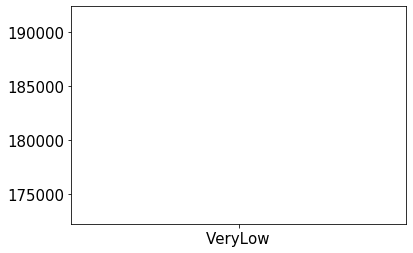

In [37]:
# Bin the MSL data
MSL_data = lagoon_model_dict['variables']['MSL']['training_data'][0]

# Grouping the bins 
MSL_bins_grouped = grouping_bins(MSL_data)

# Put the bins in the right order
df_MSL_distribution = MSL_bins_grouped.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])

# Plot the data
plt.plot(df_MSL_distribution)

## Add the Global average for now

In [38]:
# Get the preprocessed data to add to
MSL_training_data_preprocessed = lagoon_model_dict['variables']['MSL']['training_data_preprocessed'][0]
MSL_testing_data_preprocessed = lagoon_model_dict['variables']['MSL']['testing_data_preprocessed'][0]

# Print some stats to get an idea of how adding SLR will affect the data
print(np.min(MSL_training_data_preprocessed))
print(np.max(MSL_training_data_preprocessed))
print(np.mean(MSL_training_data_preprocessed))
print(np.median(MSL_training_data_preprocessed))

-0.227352272625601
0.207587280811012
-0.000515005486551021
-0.0009044489756801


In [39]:
# Based on a 2 mm/yr rate
mean_SLR_2050 = 2*29/1000
mean_SLR_2100 = 2*59/1000

# Get MSLs adjusted for regional sea level rise
MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100

In [40]:
# Using the bins from before, discretise the results
bin_edges = lagoon_model_dict['variables']['MSL']['bin_edges'][0]
bin_names = lagoon_model_dict['variables']['MSL']['discretisation']['bin_names']

# Normalise the data
df_MSL_2021 = df_MSL_distribution/np.nansum(df_MSL_distribution)

# Calculated discretised MSL for the scenarios
MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
MSL_2050_discretised = descretiser(bin_edges,bin_names,MSL_2050)
df_MSL_2050 = grouping_bins(MSL_2050_discretised)
df_MSL_2050 = df_MSL_2050.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_MSL_2050[df_MSL_2050.isna()] = 0.001
df_MSL_2050 = df_MSL_2050/np.nansum(df_MSL_2050)

# Calculated discretised MSL for the scenarios
MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100
MSL_2100_discretised = descretiser(bin_edges,bin_names,MSL_2100)
df_MSL_2100 = grouping_bins(MSL_2100_discretised)
df_MSL_2100 = df_MSL_2100.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_MSL_2100[df_MSL_2100.isna()] = 0.001
df_MSL_2100 = df_MSL_2100/np.nansum(df_MSL_2100)


### Set evidence of 2050

In [41]:
# Create dict of evidence
MSL_2050_evidence_dict = {
    'MSL':list(df_MSL_2050[0])
}

# Add evidence for MSL to the model dict
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2050_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2050_evidence_dict)

# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# TWL posterior 2050
TWL_MSL_2050_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
df_TWL_MSL_2050_posterior = pd.DataFrame.from_dict(TWL_MSL_2050_posterior_dict,orient='index')

In [42]:
# Create dict of evidence
MSL_2100_evidence_dict = {
    'MSL':list(df_MSL_2100[0])
}

# Add evidence for MSL to the model dict
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2100_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2100_evidence_dict)

# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# TWL posterior 2100
TWL_MSL_2100_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
df_TWL_MSL_2100_posterior = pd.DataFrame.from_dict(TWL_MSL_2100_posterior_dict,orient='index')

In [43]:
# get the original data to compare it to
TWL_training_dict = lagoon_model_dict['variables']['TWL_point_110']['training_data'][0]
df_TWL_training = grouping_bins(TWL_training_dict)
df_TWL_training = df_TWL_training.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_TWL_training[df_TWL_training.isna()] = 0.001
df_TWL_training = df_TWL_training/np.nansum(df_TWL_training)

# Create an extra set of dfs for data as a fraction of original
TWL_MSL_2050 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2050_posterior[0])]
TWL_MSL_2100 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2100_posterior[0])]
df_TWL_MSL_2050 = pd.DataFrame(TWL_MSL_2050).set_index(0)
df_TWL_MSL_2100 = pd.DataFrame(TWL_MSL_2100).set_index(0)

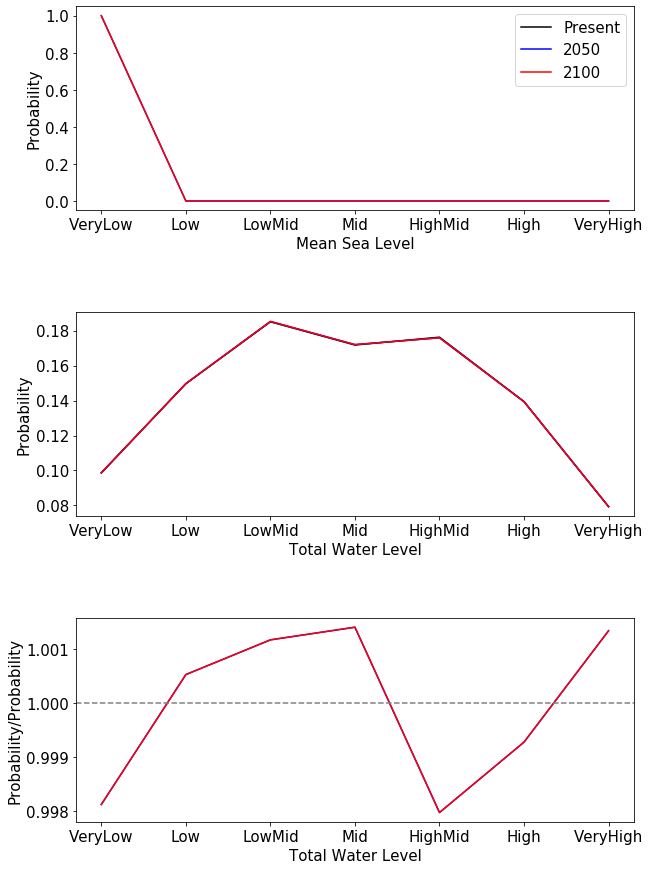

In [44]:

# Set up the figure
fig = plt.figure(figsize=(10,15))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))

# Plot MSL data and prior distributions
ax1.plot(df_MSL_2021,c='k')
ax1.plot(df_MSL_2050,c='b')
ax1.plot(df_MSL_2100,c='r')

# Plot posterior distributions compared to original data
output_2021, = ax2.plot(df_TWL_training,c='k')
output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')

# Plot posterior distributions as a fraction of the original data
output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
ax3_xlims = ax3.get_xlim()
ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
ax3.set_xlim(ax3_xlims)

# Format the graph
ax1.set_ylabel('Probability')
ax1.set_xlabel('Mean Sea Level')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Total Water Level')
ax3.set_ylabel('Probability/Probability')
ax3.set_xlabel('Total Water Level')

ax1.legend([output_2021,output_2050,output_2100],['Present','2050','2100'])


# Load in some IPCC RSL Data

In [45]:
# The IPCC data (Openheimer et al., 2019, IPCC Ch4) is relative to the 1983-2005
# Antonio's data is 1993-2017

# It's not clear to me right now if the IPCC data is relative to the 1983-2005 value globally averaged, 
# or if it varies regionally


In [46]:
import xarray as xr
tarawa_lat = 1.333
tarawa_long = 173

In [47]:
# Load the RSLD from IPCC, chapter
ds_RSLR_2040_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2040.nc')
ds_RSLR_2040_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2040.nc')
ds_RSLR_2040_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2040.nc')

ds_RSLR_2055_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2055.nc')
ds_RSLR_2055_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2055.nc')
ds_RSLR_2055_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2055.nc')

ds_RSLR_2090_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2090.nc')
ds_RSLR_2090_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2090.nc')
ds_RSLR_2090_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2090.nc')


In [48]:
# Get the RSLR for Tarawa specifically
RSLR_2040_rcp26 = float(ds_RSLR_2040_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp26 = float(ds_RSLR_2055_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp26 = float(ds_RSLR_2090_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

RSLR_2040_rcp45 = float(ds_RSLR_2040_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp45 = float(ds_RSLR_2055_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp45 = float(ds_RSLR_2090_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

RSLR_2040_rcp85 = float(ds_RSLR_2040_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp85 = float(ds_RSLR_2055_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp85 = float(ds_RSLR_2090_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

#### These values are relative to PI?? If so, I doubt Antonio's numbers are PI---so this needs to be adjusted for

### Use RCP Scenarios to set evidence

In [49]:
# Get MSLs adjusted for regional sea level rise
MSL_2040_rcp26 = MSL_training_data_preprocessed+RSLR_2040_rcp26
MSL_2055_rcp26 = MSL_training_data_preprocessed+RSLR_2055_rcp26
MSL_2090_rcp26 = MSL_training_data_preprocessed+RSLR_2090_rcp26

MSL_2040_rcp45 = MSL_training_data_preprocessed+RSLR_2040_rcp45
MSL_2055_rcp45 = MSL_training_data_preprocessed+RSLR_2055_rcp45
MSL_2090_rcp45 = MSL_training_data_preprocessed+RSLR_2090_rcp45

MSL_2040_rcp85 = MSL_training_data_preprocessed+RSLR_2040_rcp85
MSL_2055_rcp85 = MSL_training_data_preprocessed+RSLR_2055_rcp85
MSL_2090_rcp85 = MSL_training_data_preprocessed+RSLR_2090_rcp85

In [50]:
def test_model(evidence_array,model_dict):

    # Adjust MSL for difference between antonio data and IPCC data
    SLR_adjustment = 2*11/1000
    evidence_array -= SLR_adjustment
    
    # Dicretise the data
    MSL_discretised = descretiser(bin_edges,bin_names,evidence_array)
    df_MSL = grouping_bins(MSL_discretised)
    df_MSL = df_MSL.reindex(model_dict['variables']['MSL']['discretisation']['bin_names'])
    df_MSL[df_MSL.isna()] = 0.001
    df_MSL = df_MSL/np.nansum(df_MSL)
    
    # Create dict of evidence
    MSL_evidence_dict = {
        'MSL':list(df_MSL[0])
    }

    # Add evidence for MSL to the model dict
    model_dict = BNModel().add_evidence_to_dict(model_dict,MSL_evidence_dict)

    # Set evidence and get beliefs
    model_dict = BNModel().update_evidence(model_dict)

    # TWL posterior 2100
    TWL_MSL_posterior_dict = model_dict['variables']['TWL_point_110']['resulting_probs'][0]
    df_TWL_posterior = pd.DataFrame.from_dict(TWL_MSL_posterior_dict,orient='index')
    
    return(df_TWL_posterior,df_MSL)

In [51]:
IPCC_posteriors_dict = {}
MSL_prior_dict = {}

MSL_array_list = [MSL_2040_rcp26,MSL_2055_rcp26,MSL_2090_rcp26,MSL_2040_rcp45,MSL_2055_rcp45,MSL_2090_rcp45,MSL_2040_rcp85,MSL_2055_rcp85,MSL_2090_rcp85]

for array, label in zip(MSL_array_list,
                        ['RCP2.6, 2040','RCP2.6, 2055','RCP2.6, 2090','RCP4.5, 2040','RCP4.5, 2055','RCP4.5, 2090','RCP8.5, 2040','RCP8.5, 2055','RCP8.5, 2090']):
    
    df_TWL_posterior, df_MSL = test_model(array, lagoon_model_dict)
    
    IPCC_posteriors_dict.update({
        label:df_TWL_posterior
    })
    
    MSL_prior_dict.update({
        label:df_MSL
    })

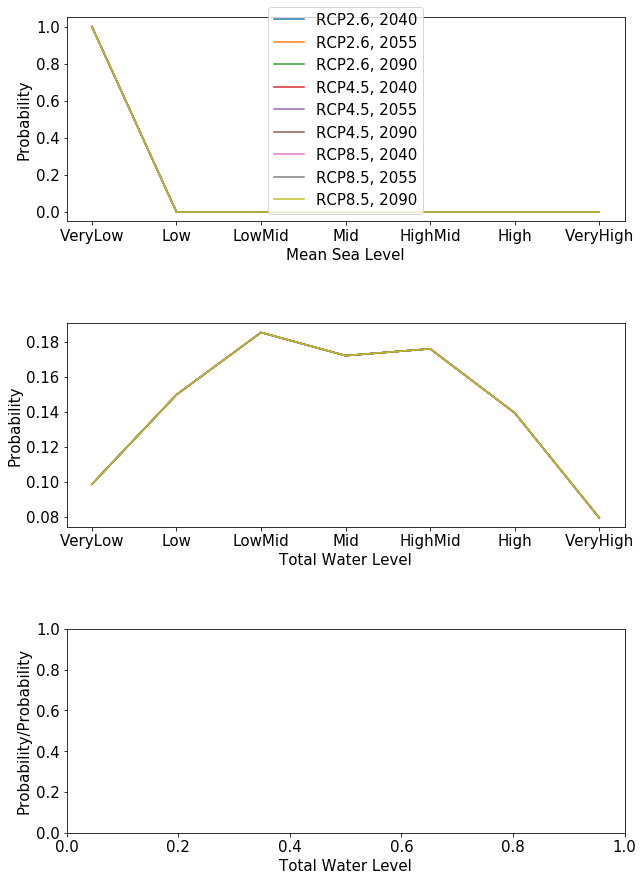

In [52]:

# Set up the figure
fig = plt.figure(figsize=(10,15))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))

# # Plot MSL data and prior distributions
# ax1.plot(df_MSL_2021,c='k')
# ax1.plot(df_MSL_2050,c='b')
# ax1.plot(df_MSL_2100,c='r')
for key,df_prior in MSL_prior_dict.items():
    ax1.plot(df_prior)

# # Plot posterior distributions compared to original data
# output_2021, = ax2.plot(df_TWL_training,c='k')
# output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')
outputs = []

for key,posterior_array in IPCC_posteriors_dict.items():
    output, = ax2.plot(posterior_array)
    outputs.append(output)

# # Plot posterior distributions as a fraction of the original data
# output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# ax3_xlims = ax3.get_xlim()
# ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# ax3.set_xlim(ax3_xlims)

# Format the graph
ax1.set_ylabel('Probability')
ax1.set_xlabel('Mean Sea Level')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Total Water Level')
ax3.set_ylabel('Probability/Probability')
ax3.set_xlabel('Total Water Level')

ax1.legend(outputs,IPCC_posteriors_dict.keys())


# Mean wave height and period

In [53]:
Hs_mean = lagoon_model_dict['variables']['Hs_offshore']['training_data_preprocessed'][0]
np.mean(Hs_mean)

0.9546159801333727

In [54]:
Tm_mean = lagoon_model_dict['variables']['Tm_offshore']['training_data_preprocessed'][0]
np.mean(Tm_mean)

3.3092462853064157

In [55]:
lagoon_model_dict['variables']['Hs_offshore']

{'label': 'Offshore wave height (m)',
 'discretisation': {'n_bins': 7,
  'strategy': 'kmeans',
  'bin_names': ['VeryLow',
   'Low',
   'LowMid',
   'Mid',
   'HighMid',
   'High',
   'VeryHigh']},
 'child_nodes': ['MSL'],
 'training_data_preprocessed': {0: array([2.01365948, 1.97455263, 1.97429192, ..., 2.05956054, 2.11108518,
         2.14895964]),
  1: array([2.01365948, 1.98831832, 1.977404  , ..., 1.98329639, 2.05956054,
         2.11108518]),
  2: array([1.98831832, 1.977404  , 1.97455263, ..., 2.05956054, 2.11108518,
         2.14895964])},
 'testing_data_preprocessed': {0: array([1.98831832, 1.977404  , 1.9809345 , ..., 1.44541728, 1.55562353,
         1.63507485]),
  1: array([1.97628891, 1.98091757, 1.97493231, ..., 1.07809567, 1.12557566,
         2.14895964]),
  2: array([2.01365948, 1.9809345 , 1.98224461, ..., 1.57556629, 1.60639691,
         1.85303426])},
 'training_data': {0: array(['VeryHigh', 'VeryHigh', 'VeryHigh', ..., 'VeryHigh', 'VeryHigh',
         'VeryHigh'], d